# Part 1: Neural Networks Basics

## Introduction

In this part, you'll implement a simple neural network for EMNIST character recognition. This will help you understand the fundamentals of neural networks, including dense layers, activation functions, and dropout.

## Learning Objectives

- Load and preprocess EMNIST dataset
- Implement a simple neural network with dense layers
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)
print('tf version:', tf.__version__)

tf version: 2.18.0


## 1. Data Loading and Preprocessing

In [2]:
# Load EMNIST dataset
# import tensorflow_datasets as tfds
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data('letters')
import tensorflow_datasets as tfds
(train, test), dataset_info = tfds.load(
  'emnist/byclass',
  split=['train', 'test'],
  as_supervised=True,
  with_info=True,
)
def preprocess_images(image, label):
    # Convert to float and normalize to [0, 1]
    # This is important because neural networks work better with normalized data
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image)
    return image, label
train = train.map(preprocess_images)
test = test.map(preprocess_images)
x_train = []
y_train = []
for image, label in tfds.as_numpy(train):
    x_train.append(image)
    y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(f'y_train shape: {y_train.shape}')

x_test = []
y_test = []
for image, label in tfds.as_numpy(test):
    x_test.append(image)
    y_test.append(label)
x_test = np.array(x_test)
y_test = np.array(y_test)
# temp = x_train[0].T
# display(temp)
# display(temp.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.POCFFX_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.POCFFX_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
y_train shape: (697932,)


In [3]:
print(f"dataset info: {dataset_info}")

dataset info: tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/root/tensorflow_datasets/emnist/byclass/3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
    }),
    

Training data shape: (697932, 28, 28, 1)
Test data shape: (116323, 28, 28, 1)
Number of classes: 62


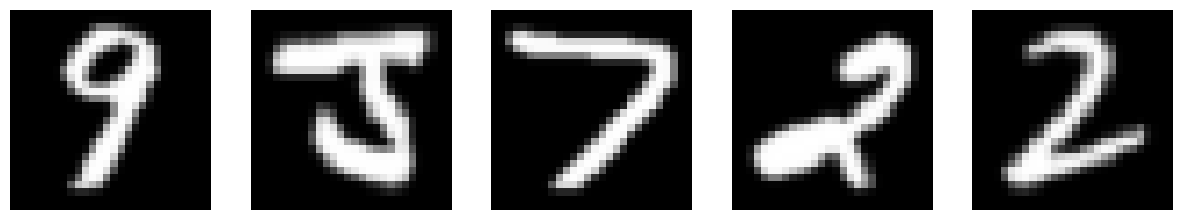

In [4]:
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    k =np.random.randint(0, len(y_test) - 1)
    plt.imshow(x_test[k], cmap='gray')
    # plt.title('Label: ',y_test[k])
    plt.axis('off')
plt.show()

In [5]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=62)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=62)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')


Preprocessed training data shape: (558345, 28, 28, 1)
Preprocessed validation data shape: (139587, 28, 28, 1)
Preprocessed test data shape: (116323, 28, 28, 1)
y_train shape: (558345, 62)
y_val shape: (139587, 62)
y_test shape: (116323, 62)


In [6]:
print(y_train.sum().sum(),y_test.sum().sum(),y_val.sum().sum())

558345.0 116323.0 139587.0


## 2. Model Implementation

In [7]:
# Create simple neural network
def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.

    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss

    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size

    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)

    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and compile model
model = create_simple_nn(input_shape=(28,28,1), num_classes=62)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             

 Total params: 2,952,958 (11.26 MB)

 Trainable params: 2,949,630 (11.25 MB)

 Non-trainable params: 3,328 (13.00 KB)

## 3. Training and Evaluation

Epoch 1/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 155s 67ms/step - accuracy: 0.8381 - loss: 0.4740 - val_accuracy: 0.8592 - val_loss: 0.4035 - learning_rate: 1.0000e-05
Epoch 2/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 176s 59ms/step - accuracy: 0.8456 - loss: 0.4452 - val_accuracy: 0.8620 - val_loss: 0.3928 - learning_rate: 1.0000e-05
Epoch 3/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 142s 59ms/step - accuracy: 0.8511 - loss: 0.4255 - val_accuracy: 0.8634 - val_loss: 0.3863 - learning_rate: 1.0000e-05
Epoch 4/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 129s 59ms/step - accuracy: 0.8553 - loss: 0.4086 - val_accuracy: 0.8647 - val_loss: 0.3805 - learning_rate: 1.0000e-05
Epoch 5/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 152s 64ms/step - accuracy: 0.8596 - loss: 0.3967 - val_accuracy: 0.8661 - val_loss: 0.3760 - learning_rate: 1.0000e-05
Epoch 6/50
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 129s 59ms/step - accuracy: 0.8622 - loss: 0.3836 - val_accuracy: 0.8663 - val_loss: 0.3726 - learning_rate: 1.0000e-05
Epoch 7/50
2182/2182 ━━━━━━━━━━━━━

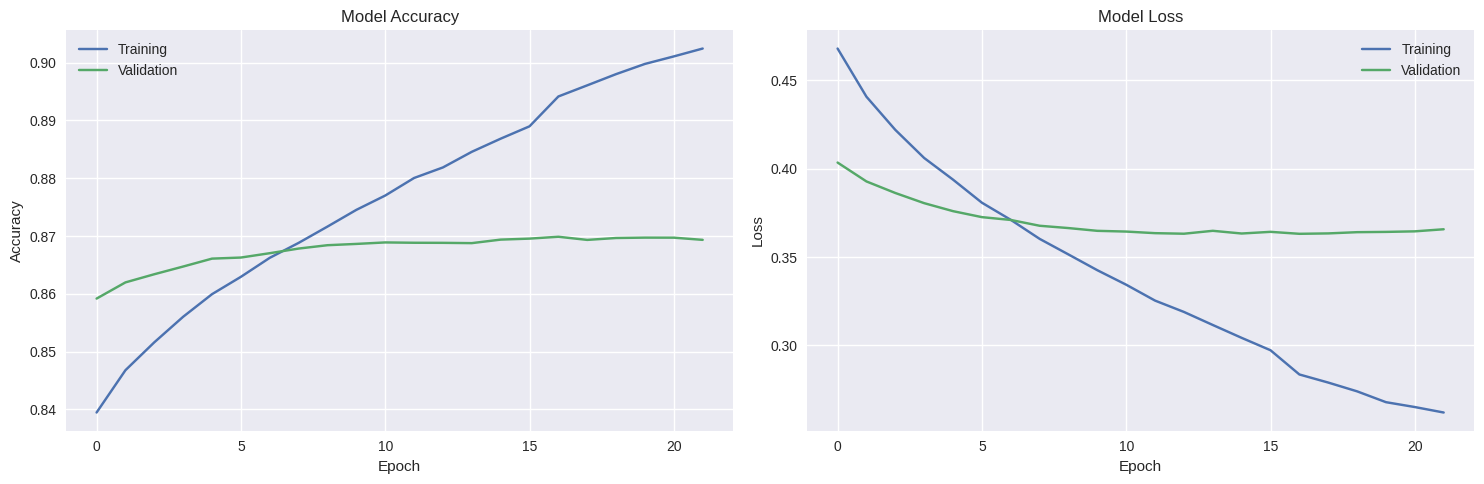

In [9]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

3636/3636 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8691 - loss: 0.3597
Test accuracy: 0.8687
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step


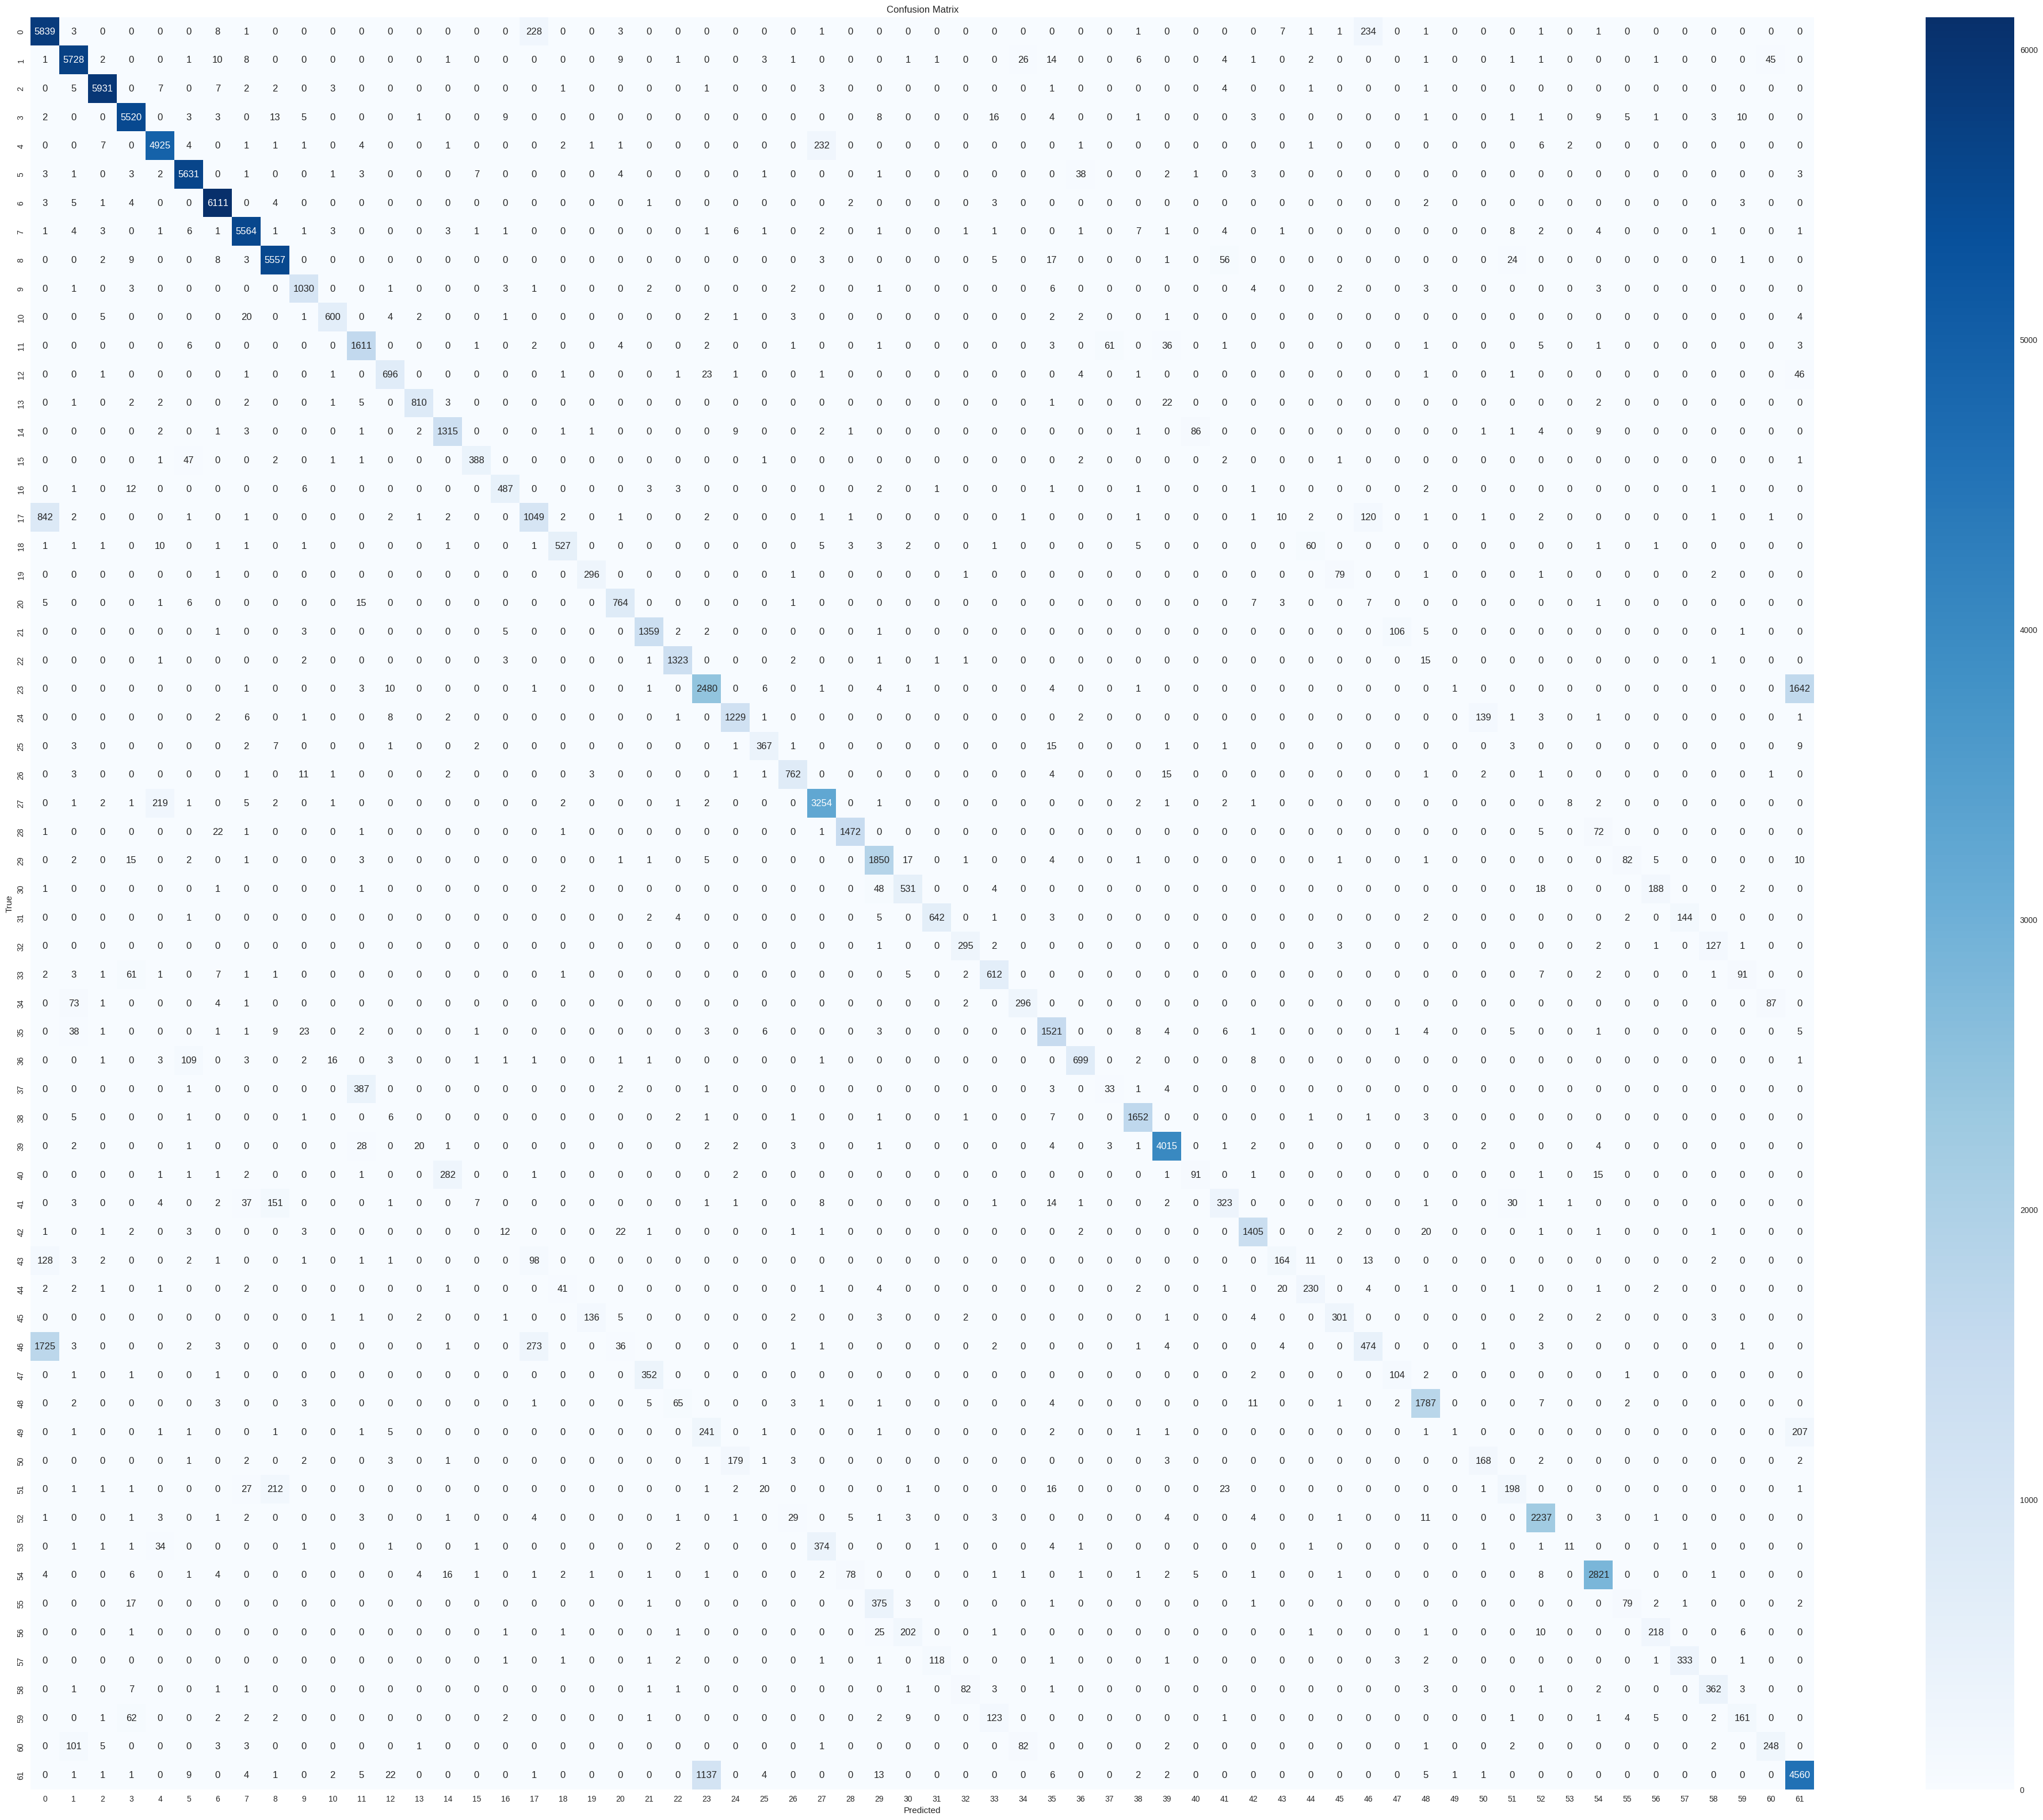

In [10]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(50, 40))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for dense layers
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create model with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in dense layers
   - Solution: Ensure data is properly reshaped to (n_samples, 784)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters